###  ---------------------------------------------------------------------------------------------------------------------------------------
##### Copyright (c) Rajdeep Biswas
##### Licensed under the MIT license.
###### File: stock_data_visualization_analysis.ipynb
###### Date: 09/26/2021
###  ---------------------------------------------------------------------------------------------------------------------------------------

### Table of Contents

* [Initial Configurations](#IC)
    * [Import Libraries](#IL)
    * [Autheticate the AML Workspace](#AML)
    * [Setup Directory Structure](#SD)
* [Visualization](#V)
    * [Calculate trading indicators](#CTI)
    * [Plot the stock ticker data](#PSD)
    * [Plot the dividend data](#PDD)
* [Prediction](#P)
    * [Prep the data](#PD)
    * [Train Test Split](#TTS)
    * [Dummy Model](#DM)  
    * [Train the model](#TRM)
    * [Test the model](#TM)
* [Strategy](#S)
    * [Assumptions](#A)
    * [Results of Simulated Investment](#R)
* [Fundamental Analysis](#FA)
    * [Prep the data](#PDF)
    * [Top 10 value stocks in S&P 500?](#TV)
    * [Top 10 growth stocks in S&P 500?](#TG)  
    * [Top 10 income stocks in S&P 500?](#TI)

### Initial Configurations <a class="anchor" id="IC"></a>

#### Import Libraries <a class="anchor" id="IL"></a>

In [1]:
#Import required Libraries
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#pip install pandas_datareader
import pandas_datareader.data as web
import pandas as pd
import datetime as dt

import azureml.core
import azureml.automl
from azureml.core import Workspace, Dataset, Datastore

#### Autheticate the AML Workspace <a class="anchor" id="AML"></a>

In [2]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.33.0 to work with houston-techsummit-workspace


In [11]:
import talib

#### Setup Directory Structure <a class="anchor" id="SD"></a>

In [3]:
data_folder = os.path.join(os.getcwd(), 'data')

#Create the data directory
os.makedirs(data_folder, exist_ok=True)

silver_data_folder = data_folder +"/silver"
os.makedirs(silver_data_folder, exist_ok=True)

gold_data_folder = data_folder +"/gold"
os.makedirs(gold_data_folder, exist_ok=True)

### Visualization <a class="anchor" id="V"></a>

In [4]:
#snp500_daily_ticker from silver directory
output_file_name = silver_data_folder + '/snp500_daily_ticker.csv'
df_snp500_daily_ticker = pd.read_csv(output_file_name)
df_snp500_daily_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624555 entries, 0 to 624554
Data columns (total 8 columns):
Date         624555 non-null object
High         624555 non-null float64
Low          624555 non-null float64
Open         624555 non-null float64
Close        624555 non-null float64
Volume       624555 non-null float64
Adj Close    624555 non-null float64
Symbol       624555 non-null object
dtypes: float64(6), object(2)
memory usage: 38.1+ MB


In [5]:
df_fb_daily_ticker = df_snp500_daily_ticker[df_snp500_daily_ticker['Symbol'] == 'FB']

In [479]:
df_fb_daily_ticker.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol
216805,2016-09-01,126.629997,125.599998,126.379997,126.169998,13536100.0,126.169998,FB
216806,2016-09-02,126.860001,126.000000,126.849998,126.510002,12118800.0,126.510002,FB
216807,2016-09-06,129.940002,126.470001,126.669998,129.729996,26278400.0,129.729996,FB
216808,2016-09-07,131.979996,129.949997,130.039993,131.050003,27990800.0,131.050003,FB
216809,2016-09-08,131.080002,129.809998,130.919998,130.270004,15676600.0,130.270004,FB


In [480]:
df_fb_daily_ticker.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol
218059,2021-08-26,369.440002,364.130005,368.380005,364.380005,7888700.0,364.380005,FB
218060,2021-08-27,373.739990,364.079987,365.100006,372.630005,11214200.0,372.630005,FB
218061,2021-08-30,381.489990,370.519989,372.559998,380.660004,13547300.0,380.660004,FB
218062,2021-08-31,382.760010,378.799988,379.950012,379.380005,12339400.0,379.380005,FB
218063,2021-09-01,384.329987,378.970001,379.589996,383.119995,9541520.0,383.119995,FB


#### Calculate trading indicators <a class="anchor" id="CTI"></a>

Calculate trading indicators  
Trading indicators are mathematical calculations, which are plotted as lines on a price chart and
can help traders identify certain signals and trends within the market.  

Moving Average  
The moving average (MA) is used to identify the direction of a current price trend, without the interference of shorter-term price spikes.
The MA indicator combines price points of a stock over a specified time frame and divides it by the number of data points to present a single trend line.
Let’s calculate 20 days (short term) and 200 days (long term) MA on TSLA Closing prices (we can calculate MA directly with pandas)  
    
Why are the moving averages important?  
Moving averages are used to identify significant support and resistance levels.
Traders watch for crossovers of longer-term moving averages by shorter-term moving averages as possible indicators of trend changes to enter long and short positions.
According to Stan Weinstein: The price must be above the short term MA in order to buy a stock.    

In [8]:
df_fb_daily_ticker.loc[:, 'ma20'] = df_fb_daily_ticker.Close.rolling(20).mean()
df_fb_daily_ticker.loc[:, 'ma200'] = df_fb_daily_ticker.Close.rolling(200).mean()

In [482]:
df_fb_daily_ticker.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol,ma20,ma200
218059,2021-08-26,369.440002,364.130005,368.380005,364.380005,7888700.0,364.380005,FB,360.500002,304.19555
218060,2021-08-27,373.739990,364.079987,365.100006,372.630005,11214200.0,372.630005,FB,361.316502,304.69655
218061,2021-08-30,381.489990,370.519989,372.559998,380.660004,13547300.0,380.660004,FB,362.752002,305.21745
218062,2021-08-31,382.760010,378.799988,379.950012,379.380005,12339400.0,379.380005,FB,364.159003,305.73895
218063,2021-09-01,384.329987,378.970001,379.589996,383.119995,9541520.0,383.119995,FB,365.369002,306.26980


In [7]:
df_fb_daily_ticker = df_fb_daily_ticker.sort_values('Date', ascending = True).reset_index(drop=True)

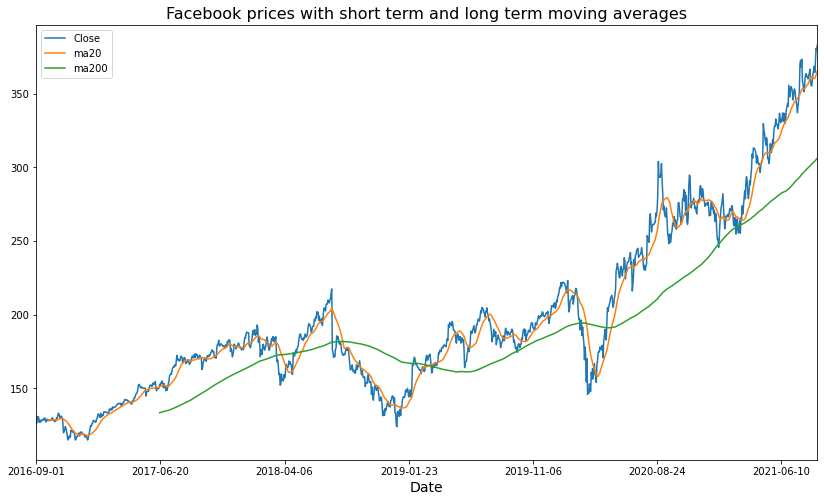

In [66]:
fig, ax = plt.subplots(figsize=(14, 8))
l = ax.get_xlabel()
ax.set_xlabel(l,fontsize=14)
ax.set_ylabel(l,fontsize=14)
plt.rcParams["axes.titlesize"] = 16
ax.set_title('Facebook prices with short term and long term moving averages')
df_fb_daily_ticker.plot(x="Date", y=["Close", "ma20", "ma200"], ax=ax)
plt.show()

RSI — Relative Strength Index  
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude
of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.  
The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a
reading from 0 to 100. It is most typically used on a 14-day timeframe.  

An asset with RSI ≥70 is often considered overbought, while an asset with RSI ≤ 30 is often considered oversold:  
- an overbought signal suggests that assets may be in for a price correction.  
- an oversold signal could mean that short-term declines are reaching maturity and assets may be in for a rally.  

In [12]:
df_fb_daily_ticker.loc[:, "rsi"] = talib.RSI(df_fb_daily_ticker.Close, 14)
df_fb_daily_ticker.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol,ma20,ma200,rsi
1254,2021-08-26,369.440002,364.130005,368.380005,364.380005,7888700.0,364.380005,FB,360.500002,304.19555,55.715240
1255,2021-08-27,373.739990,364.079987,365.100006,372.630005,11214200.0,372.630005,FB,361.316502,304.69655,62.373230
1256,2021-08-30,381.489990,370.519989,372.559998,380.660004,13547300.0,380.660004,FB,362.752002,305.21745,67.495664
1257,2021-08-31,382.760010,378.799988,379.950012,379.380005,12339400.0,379.380005,FB,364.159003,305.73895,65.954314
1258,2021-09-01,384.329987,378.970001,379.589996,383.119995,9541520.0,383.119995,FB,365.369002,306.26980,68.236737


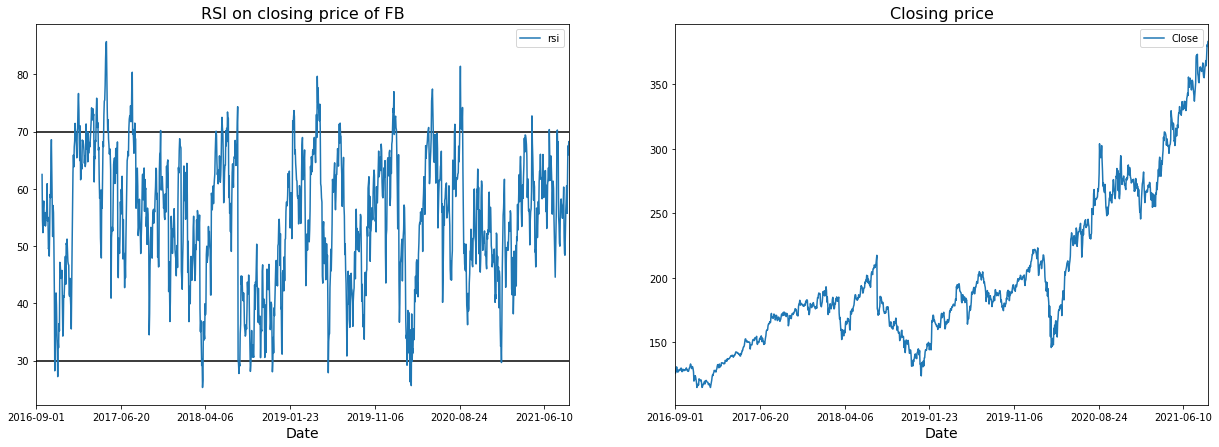

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))
l0 = ax[0].get_xlabel()
ax[0].set_xlabel(l0,fontsize=14)
ax[0].set_ylabel(l0,fontsize=14)

l1 = ax[1].get_xlabel()
ax[1].set_xlabel(l1,fontsize=14)
ax[1].set_ylabel(l1,fontsize=14)


plt.rcParams["axes.titlesize"] = 16
ax[0].axhline(30, color="black")
ax[0].axhline(70, color="black")

ax[0].set_title("RSI on closing price of FB")
ax[1].set_title("Closing price")

df_fb_daily_ticker.plot(x="Date", y=["rsi"], ax=ax[0])
df_fb_daily_ticker.plot(x="Date", y=["Close"], ax=ax[1])
plt.show()

#### Plot the stock ticker data <a class="anchor" id="PSD"></a>

Plot the stock data  
In this section, we are going to see how to plot an OHLC chart — a chart with bars Open, 
High, Low, Close prices, that we are used to seeing on trading platforms.  
We are going to use the Plotly library for the OHLC chart.  

In [45]:
import plotly.graph_objects as go

In [69]:
fig = go.Figure(
    data=go.Ohlc(
        x=df_fb_daily_ticker.Date,
        open=df_fb_daily_ticker["Open"],
        high=df_fb_daily_ticker["High"],
        low=df_fb_daily_ticker["Low"],
        close=df_fb_daily_ticker["Close"],
    )
)
fig.show()

#### Plot the dividend data <a class="anchor" id="PDD"></a>

In [48]:
#snp500 dividend data from silver directory
output_file_name = silver_data_folder + '/snp500_dividend_split.csv'
df_snp500_dividend_split = pd.read_csv(output_file_name)
df_snp500_dividend_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7870 entries, 0 to 7869
Data columns (total 4 columns):
Date      7870 non-null object
action    7870 non-null object
value     7870 non-null float64
Symbol    7870 non-null object
dtypes: float64(1), object(3)
memory usage: 246.1+ KB


In [49]:
df_snp500_dividend_split.head()

,Date,action,value,Symbol
0,2020-02-04,DIVIDEND,0.1,AAL
1,2019-11-05,DIVIDEND,0.1,AAL
2,2019-08-06,DIVIDEND,0.1,AAL
3,2019-05-07,DIVIDEND,0.1,AAL
4,2019-02-05,DIVIDEND,0.1,AAL


In [54]:
df_snp500_dividends = df_snp500_dividend_split[df_snp500_dividend_split['action'] == 'DIVIDEND']

In [55]:
df_AAPL_dividend = df_snp500_dividends[df_snp500_dividends['Symbol'] == 'AAPL' ]

In [57]:
df_AAPL_dividend.tail()

,Date,action,value,Symbol
29,2017-11-10,DIVIDEND,0.1575,AAPL
30,2017-08-10,DIVIDEND,0.1575,AAPL
31,2017-05-11,DIVIDEND,0.1575,AAPL
32,2017-02-09,DIVIDEND,0.1425,AAPL
33,2016-11-03,DIVIDEND,0.1425,AAPL


In [62]:
# sort, then reset index
df_AAPL_dividend = df_AAPL_dividend.sort_values('Date', ascending = True).reset_index(drop=True)

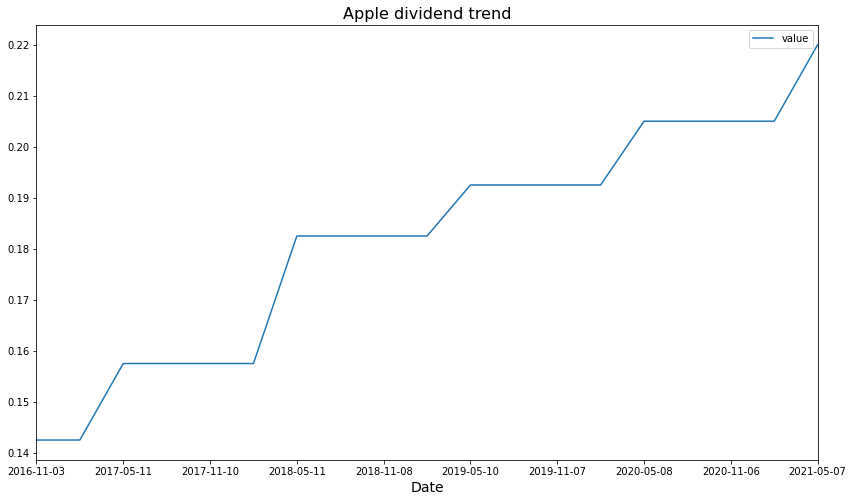

In [64]:
fig, ax = plt.subplots(figsize=(14, 8))
l = ax.get_xlabel()
ax.set_xlabel(l,fontsize=14)
ax.set_ylabel(l,fontsize=14)
plt.rcParams["axes.titlesize"] = 16
ax.set_title('Apple dividend trend')
df_AAPL_dividend.plot(x="Date", y=["value"], ax=ax)
plt.show()

### Prediction <a class="anchor" id="P"></a> 

We will start working with FB data for now since we already filtered the Dataframe

In [485]:
df_fb_daily_ticker.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol,ma20,ma200,rsi
1254,2021-08-26,369.440002,364.130005,368.380005,364.380005,7888700.0,364.380005,FB,360.500002,304.19555,55.715240
1255,2021-08-27,373.739990,364.079987,365.100006,372.630005,11214200.0,372.630005,FB,361.316502,304.69655,62.373230
1256,2021-08-30,381.489990,370.519989,372.559998,380.660004,13547300.0,380.660004,FB,362.752002,305.21745,67.495664
1257,2021-08-31,382.760010,378.799988,379.950012,379.380005,12339400.0,379.380005,FB,364.159003,305.73895,65.954314
1258,2021-09-01,384.329987,378.970001,379.589996,383.119995,9541520.0,383.119995,FB,365.369002,306.26980,68.236737


#### Prep the data <a class="anchor" id="PD"></a>

In [13]:
df_fb_daily_ticker.loc[:, "ema"] = talib.EMA(df_fb_daily_ticker['Adj Close'], 14)
df_fb_daily_ticker.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol,ma20,ma200,rsi,ema
1254,2021-08-26,369.440002,364.130005,368.380005,364.380005,7888700.0,364.380005,FB,360.500002,304.19555,55.715240,361.945101
1255,2021-08-27,373.739990,364.079987,365.100006,372.630005,11214200.0,372.630005,FB,361.316502,304.69655,62.373230,363.369755
1256,2021-08-30,381.489990,370.519989,372.559998,380.660004,13547300.0,380.660004,FB,362.752002,305.21745,67.495664,365.675122
1257,2021-08-31,382.760010,378.799988,379.950012,379.380005,12339400.0,379.380005,FB,364.159003,305.73895,65.954314,367.502439
1258,2021-09-01,384.329987,378.970001,379.589996,383.119995,9541520.0,383.119995,FB,365.369002,306.26980,68.236737,369.584780


In [77]:
df_fb_daily_ticker.head(201)

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol,ma20,ma200,rsi,ema
0,2016-09-01,126.629997,125.599998,126.379997,126.169998,13536100.0,126.169998,FB,NaN,NaN,NaN,NaN
1,2016-09-02,126.860001,126.000000,126.849998,126.510002,12118800.0,126.510002,FB,NaN,NaN,NaN,NaN
2,2016-09-06,129.940002,126.470001,126.669998,129.729996,26278400.0,129.729996,FB,NaN,NaN,NaN,NaN
3,2016-09-07,131.979996,129.949997,130.039993,131.050003,27990800.0,131.050003,FB,NaN,NaN,NaN,NaN
4,2016-09-08,131.080002,129.809998,130.919998,130.270004,15676600.0,130.270004,FB,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
196,2017-06-14,152.399994,149.050003,151.259995,150.250000,20808800.0,150.250000,FB,150.661502,NaN,50.090731,151.052607
197,2017-06-15,150.039993,146.369995,147.669998,149.800003,18994200.0,149.800003,FB,150.909002,NaN,48.713941,150.885593
198,2017-06-16,150.830002,148.600006,149.589996,150.639999,22882400.0,150.639999,FB,151.058002,NaN,51.399317,150.852847
199,2017-06-19,153.570007,151.710007,151.710007,152.869995,19026500.0,152.869995,FB,151.298502,133.5732,57.727449,151.121800


In [78]:
#Drop the first 199 rows
df_fb_daily_ticker = df_fb_daily_ticker.iloc[199:]
df_fb_daily_ticker.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Symbol,ma20,ma200,rsi,ema
199,2017-06-19,153.570007,151.710007,151.710007,152.869995,19026500.0,152.869995,FB,151.298502,133.57320,57.727449,151.121800
200,2017-06-20,153.839996,152.210007,152.880005,152.250000,14743900.0,152.250000,FB,151.499001,133.70360,55.561366,151.272227
201,2017-06-21,154.080002,151.880005,152.360001,153.910004,15039800.0,153.910004,FB,151.791001,133.84060,59.899905,151.623930
202,2017-06-22,154.550003,152.910004,153.009995,153.399994,13005500.0,153.399994,FB,151.959001,133.95895,58.025532,151.860739
203,2017-06-23,155.199997,152.649994,152.720001,155.070007,18027000.0,155.070007,FB,152.114501,134.07905,62.196943,152.288641


In [79]:
#Check for null values
df_fb_daily_ticker.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
Symbol       0
ma20         0
ma200        0
rsi          0
ema          0
dtype: int64

Let us take a quick look at a plot of our data now to get an idea of how the the technical 
indicators value tracks with the adjusted closing price.

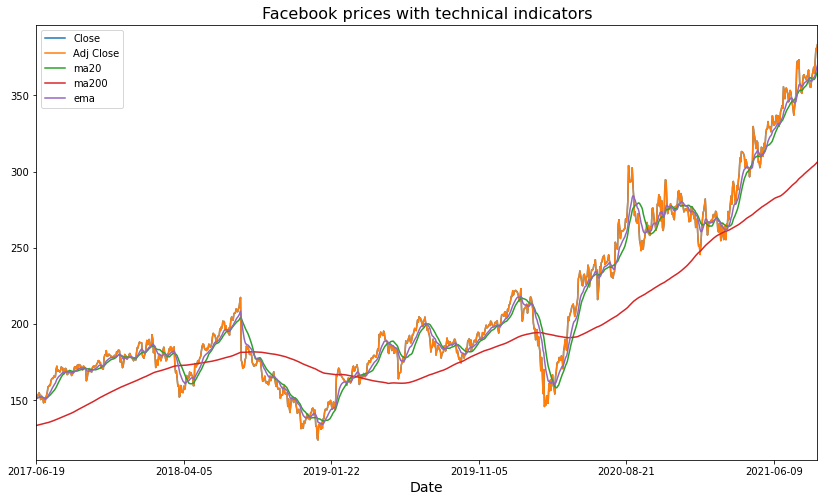

In [81]:
fig, ax = plt.subplots(figsize=(14, 8))
l = ax.get_xlabel()
ax.set_xlabel(l,fontsize=14)
ax.set_ylabel(l,fontsize=14)
plt.rcParams["axes.titlesize"] = 16
ax.set_title('Facebook prices with technical indicators')
df_fb_daily_ticker.plot(x="Date", y=["Close", "Adj Close", "ma20", "ma200", "ema"], ax=ax)
plt.show()

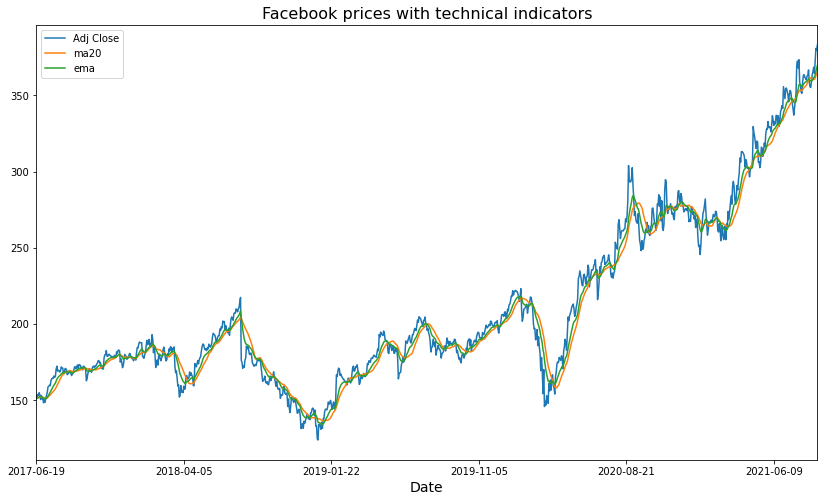

In [85]:
fig, ax = plt.subplots(figsize=(14, 8))
l = ax.get_xlabel()
ax.set_xlabel(l,fontsize=14)
ax.set_ylabel(l,fontsize=14)
plt.rcParams["axes.titlesize"] = 16
ax.set_title('Facebook prices with technical indicators')
df_fb_daily_ticker.plot(x="Date", y=["Adj Close", "ma20", "ema"], ax=ax)
plt.show()

#### Train Test Split <a class="anchor" id="TTS"></a>

In [89]:
X = df_fb_daily_ticker[['High', 'Low', 'Open', 'Volume', 'ma20', 'ema']]
y = df_fb_daily_ticker['Adj Close']

In [96]:
#Splitting the data to train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#### Dummy Model <a class="anchor" id="DM"></a>

In [115]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='mean')
# "Train" model
dummy.fit(X_train, y_train)

DummyRegressor()

Returns the coefficient of determination R^2 of the prediction.  

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [119]:
dummy.score(X_test, y_test)

-0.0027921353115005765

#### Train the model <a class="anchor" id="TRM"></a>

In [120]:
from sklearn.linear_model import LinearRegression
# Create Regression Model
lm_model = LinearRegression()
# Train the model
lm_model.fit(X_train, y_train)

LinearRegression()

#### Test the model <a class="anchor" id="TM"></a>

The MAE is the arithmetic mean of the absolute errors of our model, calculated
by summing the absolute difference between observed values of X and Y and dividing by the total number of observations.  

The MAE can be described as sum of the absolute error for all observed values divided by the total number of observations.  

In [121]:
y_pred = lm_model.predict(X_test)

In [123]:
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", lm_model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("Root mean squared error:", math.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Model Coefficients: [ 6.78375500e-01  8.13762142e-01 -5.39603712e-01  2.29264127e-09
 -5.33522131e-02  1.03143440e-01]
Mean Absolute Error: 1.1363660718945514
Mean squared error: 2.6434815449000957
Root mean squared error: 1.6258786993192622
Coefficient of Determination: 0.9992446176844479


In [124]:
quick_test = pd.DataFrame({'Actual': y_test, 'Predicted' : y_pred})
quick_test.head()

,Actual,Predicted
529,157.899994,159.895071
314,177.179993,176.972390
1073,285.579987,285.442088
991,256.130005,260.414952
271,170.869995,171.028737


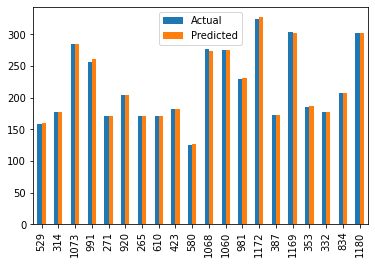

In [125]:
graph = quick_test.head(20)
graph.plot(kind='bar')

### Strategy <a class="anchor" id="S"></a>
If our model predicts a higher closing value than the opening value we make a trade for a single share on that day—buying at market open and selling just before market close.

In [132]:
df_fb_daily_ticker_t = df_fb_daily_ticker[['Date','High', 'Low', 'Open', 'Volume', 'ma20', 'ema','Adj Close']]

In [133]:
all_pred = lm_model.predict(X)

In [134]:
df_fb_daily_ticker_t['Predicted Close'] = all_pred

In [136]:
df_fb_daily_ticker_t = df_fb_daily_ticker_t.sort_values('Date', ascending = True).reset_index(drop=True)

In [137]:
df_fb_daily_ticker_t.tail()

,Date,High,Low,Open,Volume,ma20,ema,Adj Close,Predicted Close
1055,2021-08-26,369.440002,364.130005,368.380005,7888700.0,360.500002,361.945101,364.380005,366.182237
1056,2021-08-27,373.739990,364.079987,365.100006,11214200.0,361.316502,363.369755,372.630005,370.939445
1057,2021-08-30,381.489990,370.519989,372.559998,13547300.0,362.752002,365.675122,380.660004,377.578592
1058,2021-08-31,382.760010,378.799988,379.950012,12339400.0,364.159003,367.502439,379.380005,381.301052
1059,2021-09-01,384.329987,378.970001,379.589996,9541520.0,365.369002,369.584780,383.119995,382.842512


In [138]:
df_fb_daily_ticker_t['Buy'] = (df_fb_daily_ticker_t['Predicted Close'] - df_fb_daily_ticker_t['Open']) > 0

In [139]:
df_fb_daily_ticker_t.tail()

,Date,High,Low,Open,Volume,ma20,ema,Adj Close,Predicted Close,Buy
1055,2021-08-26,369.440002,364.130005,368.380005,7888700.0,360.500002,361.945101,364.380005,366.182237,False
1056,2021-08-27,373.739990,364.079987,365.100006,11214200.0,361.316502,363.369755,372.630005,370.939445,True
1057,2021-08-30,381.489990,370.519989,372.559998,13547300.0,362.752002,365.675122,380.660004,377.578592,True
1058,2021-08-31,382.760010,378.799988,379.950012,12339400.0,364.159003,367.502439,379.380005,381.301052,True
1059,2021-09-01,384.329987,378.970001,379.589996,9541520.0,365.369002,369.584780,383.119995,382.842512,True


In [199]:
df_fb_daily_ticker_t['Gain per stock'] = (df_fb_daily_ticker_t['Adj Close'] - df_fb_daily_ticker_t['Open'])
df_fb_daily_ticker_t.tail()

,Date,High,Low,Open,Volume,ma20,ema,Adj Close,Predicted Close,Buy,Gain per stock
1055,2021-08-26,369.440002,364.130005,368.380005,7888700.0,360.500002,361.945101,364.380005,366.182237,False,-4.000000
1056,2021-08-27,373.739990,364.079987,365.100006,11214200.0,361.316502,363.369755,372.630005,370.939445,True,7.529999
1057,2021-08-30,381.489990,370.519989,372.559998,13547300.0,362.752002,365.675122,380.660004,377.578592,True,8.100006
1058,2021-08-31,382.760010,378.799988,379.950012,12339400.0,364.159003,367.502439,379.380005,381.301052,True,-0.570007
1059,2021-09-01,384.329987,378.970001,379.589996,9541520.0,365.369002,369.584780,383.119995,382.842512,True,3.529999


In [200]:
df_fb_daily_ticker_t['Gain per stock'] = df_fb_daily_ticker_t['Gain per stock'].apply(lambda x: x
                                                                         if x > 0 else 0)
df_fb_daily_ticker_t.tail()

,Date,High,Low,Open,Volume,ma20,ema,Adj Close,Predicted Close,Buy,Gain per stock
1055,2021-08-26,369.440002,364.130005,368.380005,7888700.0,360.500002,361.945101,364.380005,366.182237,False,0.000000
1056,2021-08-27,373.739990,364.079987,365.100006,11214200.0,361.316502,363.369755,372.630005,370.939445,True,7.529999
1057,2021-08-30,381.489990,370.519989,372.559998,13547300.0,362.752002,365.675122,380.660004,377.578592,True,8.100006
1058,2021-08-31,382.760010,378.799988,379.950012,12339400.0,364.159003,367.502439,379.380005,381.301052,True,0.000000
1059,2021-09-01,384.329987,378.970001,379.589996,9541520.0,365.369002,369.584780,383.119995,382.842512,True,3.529999


#### Assumptions <a class="anchor" id="A"></a>

1. We were able to purchase a share at the exact price recorded as the historic opening price;
2. We were able to sell that share just before closing at the exact priced recorded as the historic closing price.


#### Results of Simulated Investment <a class="anchor" id="R"></a>
Let us try this for 100 days with $1000

In [201]:
df_fb_daily_ticker_t100 = df_fb_daily_ticker_t.tail(100)

In [202]:
df_fb_daily_ticker_t100["Num of Stocks"] = 1000/df_fb_daily_ticker_t100['Open']

In [203]:
#df_fb_daily_ticker_t100["Num of Stocks"] = df_fb_daily_ticker_t['Gain per stock', 'Num of Stocks'].apply(lambda x: x['Num of Stocks'] if x['Gain per stock'] > 0 else 0, axis=1 )

In [204]:
df_fb_daily_ticker_t100["Day Gain"] = df_fb_daily_ticker_t100["Num of Stocks"] * df_fb_daily_ticker_t100["Gain per stock"]

In [205]:
df_fb_daily_ticker_t100.head()

,Date,High,Low,Open,Volume,ma20,ema,Adj Close,Predicted Close,Buy,Gain per stock,Num of Stocks,Day Gain
960,2021-04-13,314.429993,309.320007,312.209991,14036900.0,295.357001,301.569267,309.760010,311.834288,False,0.000000,3.202972,0.000000
961,2021-04-14,308.029999,301.950012,307.299988,17421400.0,296.534001,301.736032,302.820007,304.106887,False,0.000000,3.254149,0.000000
962,2021-04-15,310.140015,304.100006,306.339996,14558300.0,297.724501,302.547229,307.820007,307.819458,True,1.480011,3.264347,4.831269
963,2021-04-16,308.950012,304.609985,308.170013,13059200.0,299.102501,303.031597,306.179993,306.412711,False,0.000000,3.244962,0.000000
964,2021-04-19,307.700012,300.559998,305.010010,14553500.0,299.709001,302.926050,302.239990,303.934346,False,0.000000,3.278581,0.000000


In [206]:
total_gain = df_fb_daily_ticker_t100["Day Gain"].sum()

In [207]:
total_gain

583.9491245956691

In [208]:
print ("Profit percentage on investing $1000 is", round((total_gain/1000)*100,2), "%")

Profit percentage on investing $1000 is 58.39 %


### Fundamental Analysis <a class="anchor" id="FA"></a>

#### Prep the data <a class="anchor" id="PDF"></a>

In [209]:
import yahoo_fin.stock_info as si

In [210]:
val = si.get_stats_valuation("aapl")
val

,Unnamed: 0,As of Date: 9/18/2021Current,6/30/2021,3/31/2021,12/31/2020,9/30/2020,6/30/2020
0,Market Cap (intraday) 5,2.41T,2.27T,2.04T,2.23T,1.97T,1.56T
1,Enterprise Value 3,2.47T,2.32T,2.07T,2.25T,1.99T,1.58T
2,Trailing P/E,28.53,30.64,32.92,40.45,35.12,28.52
3,Forward P/E 1,26.25,25.77,28.49,33.44,30.12,24.33
4,PEG Ratio (5 yr expected) 1,2.00,2.12,2.71,3.33,2.86,2.02
5,Price/Sales (ttm),7.16,7.23,7.21,8.47,7.50,6.12
6,Price/Book (mrq),37.56,32.78,30.78,34.16,27.20,19.93
7,Enterprise Value/Revenue 3,7.13,28.48,23.15,20.22,30.69,26.44
8,Enterprise Value/EBITDA 7,21.62,83.24,65.87,61.11,108.89,95.15


In [211]:
val = val.iloc[:,:2]
val.columns = ["Attribute", "Recent"]

In [212]:
trailing_pe = float(val[val.Attribute.str.contains("Trailing P/E")].iloc[0,1])
trailing_pe

28.53

In [ ]:
forward_pe = float(val[val.Attribute.str.contains("Forward P/E")].iloc[0,1])
ps = float(val[val.Attribute.str.contains("Price/Sales")].iloc[0,1])
pb = float(val[val.Attribute.str.contains("Price/Book")].iloc[0,1])
peg = float(val[val.Attribute.str.contains("PEG Ratio")].iloc[0,1])
cap = float(val[val.Attribute.str.contains("Market Cap")].iloc[0,1])

In [242]:
sector = si.get_company_info("aapl")['Value'][1]
sector

'Technology'

In [282]:
si.get_company_info("aapl")['Value'][18]

'Consumer Electronics'

In [286]:
si.get_company_info("a")['Value'][19]

'Diagnostics & Research'

In [291]:
si.get_company_info("aapl")['Value'][len(si.get_company_info("aapl")['Value'])-1]

'Consumer Electronics'

In [315]:
si.get_company_info("AES").loc[['industry']]['Value'][0]

'Utilities—Diversified'

In [325]:
si.get_stats_valuation("AAPL")

,Unnamed: 0,As of Date: 9/17/2021Current,6/30/2021,3/31/2021,12/31/2020,9/30/2020,6/30/2020
0,Market Cap (intraday) 5,16.18B,17.37B,17.86B,15.64B,12.05B,9.63B
1,Enterprise Value 3,35.74B,36.23B,36.32B,35.09B,31.58B,28.85B
2,Trailing P/E,NaN,NaN,446.83,NaN,64.68,32.93
3,Forward P/E 1,14.51,16.72,17.24,15.17,11.92,10.50
4,PEG Ratio (5 yr expected) 1,1.85,2.14,2.27,2.21,1.71,1.62
5,Price/Sales (ttm),1.55,1.75,1.85,1.64,1.27,0.98
6,Price/Book (mrq),7.28,7.44,6.78,7.80,4.89,3.79
7,Enterprise Value/Revenue 3,3.42,13.42,13.78,13.71,12.41,13.01
8,Enterprise Value/EBITDA 7,17.66,97.91,76.62,30.76,831.04,48.57


The Difference Between the Dividend Rate and Dividend Yield  
Dividend rate is the absolute amount of dividends being paid quarterly or yearly, while dividend yield measures the dividend paid as a percentage of the equity," O'Keefe explains. "Dividend yield gives investors an idea of how much income they can expect to receive relative to their equity investment on a periodic basis.

In [268]:
import re
divy = si.get_quote_table("aapl")['Forward Dividend & Yield']
divy_ar = re.split(r'\(|\)|%',divy)
forward_dividend = divy_ar[0]
div_yield = divy_ar[1]

In [336]:
!python -V

Python 3.6.9 :: Anaconda, Inc.


In [341]:
import importlib
import yahoo_fin.stock_info as si
importlib.reload(si)

<module 'yahoo_fin.stock_info' from '/anaconda/envs/azureml_py36/lib/python3.6/site-packages/yahoo_fin/stock_info.py'>

In [348]:
snp500_list = si.tickers_sp500()[35:]

In [349]:
snp500_list[0]

'ANET'

In [384]:
import time
from time import sleep
import importlib
snp500_list = si.tickers_sp500()[475:]
#fundamentals_columns = ['symbol','sector','industry','market_cap','trailing_pe','forward_pe','ps','pb','peg',
#                       'forward_dividend','div_yield']
#fundamentals_df = pd.DataFrame(columns=fundamentals_columns)
index = 475
for ticker in snp500_list:
    try:
        #print(ticker)
        val = si.get_stats_valuation(ticker)
        val = val.iloc[:,:2]
        val.columns = ["Attribute", "Recent"]    
        trailing_pe = float(val[val.Attribute.str.contains("Trailing P/E")].iloc[0,1])
        forward_pe = float(val[val.Attribute.str.contains("Forward P/E")].iloc[0,1])
        ps = float(val[val.Attribute.str.contains("Price/Sales")].iloc[0,1])
        pb = float(val[val.Attribute.str.contains("Price/Book")].iloc[0,1])
        peg = float(val[val.Attribute.str.contains("PEG Ratio")].iloc[0,1])
        cap = val[val.Attribute.str.contains("Market Cap")].iloc[0,1]

        sector = si.get_company_info(ticker).loc[['sector']]['Value'][0]
        industry = si.get_company_info(ticker).loc[['industry']]['Value'][0]

        divy = si.get_quote_table(ticker)['Forward Dividend & Yield']
        divy_ar = re.split(r'\(|\)|%',divy)
        forward_dividend = divy_ar[0]
        div_yield = divy_ar[1]    

        new_row =[ticker,sector,industry,cap,trailing_pe,forward_pe,ps,pb,peg,forward_dividend,div_yield]
        # using the loc indexer
        fundamentals_df.loc[index] = new_row
        index = index + 1
        #break
    except Exception as e:
        print (index,ticker)
        sleep(300)
        import yahoo_fin.stock_info as si
        importlib.reload(si)
        val = si.get_stats_valuation(ticker)
        val = val.iloc[:,:2]
        val.columns = ["Attribute", "Recent"]    
        trailing_pe = float(val[val.Attribute.str.contains("Trailing P/E")].iloc[0,1])
        forward_pe = float(val[val.Attribute.str.contains("Forward P/E")].iloc[0,1])
        ps = float(val[val.Attribute.str.contains("Price/Sales")].iloc[0,1])
        pb = float(val[val.Attribute.str.contains("Price/Book")].iloc[0,1])
        peg = float(val[val.Attribute.str.contains("PEG Ratio")].iloc[0,1])
        cap = val[val.Attribute.str.contains("Market Cap")].iloc[0,1]

        sector = si.get_company_info(ticker).loc[['sector']]['Value'][0]
        industry = si.get_company_info(ticker).loc[['industry']]['Value'][0]

        divy = si.get_quote_table(ticker)['Forward Dividend & Yield']
        divy_ar = re.split(r'\(|\)|%',divy)
        forward_dividend = divy_ar[0]
        div_yield = divy_ar[1]    

        new_row =[ticker,sector,industry,cap,trailing_pe,forward_pe,ps,pb,peg,forward_dividend,div_yield]
        # using the loc indexer
        fundamentals_df.loc[index] = new_row
        index = index + 1        

482 WELL
488 WMT
494 WYNN
500 YUM


In [354]:
fundamentals_df.head(100)

,symbol,sector,industry,market_cap,trailing_pe,forward_pe,ps,pb,peg,forward_dividend,div_yield
0,ANET,Technology,Computer Hardware,27.55B,39.21,31.06,10.86,7.45,2.30,N/A,N/A
1,ANSS,Technology,Software—Application,31.81B,69.85,45.45,17.76,7.49,3.71,N/A,N/A
2,ANTM,Healthcare,Healthcare Plans,92.53B,22.22,13.32,0.75,2.65,1.19,4.52,1.19
3,AON,Financial Services,Insurance Brokers,65.29B,31.75,23.09,5.66,14.63,2.01,2.04,0.71
4,AOS,Industrials,Specialty Industrial Machinery,10.39B,24.09,20.62,3.29,5.72,2.06,1.04,1.59
5,APA,Energy,Oil & Gas E&P,7.61B,10.71,6.72,1.28,NaN,3.36,0.10,0.50
6,APD,Basic Materials,Chemicals,57.96B,29.75,24.94,5.94,4.43,1.46,6.00,2.29
7,APH,Technology,Electronic Components,45.29B,33.58,27.55,4.81,7.92,1.94,0.58,0.85
8,APTV,Consumer Cyclical,Auto Parts,39.61B,41.02,27.86,2.58,4.76,1.17,N/A,N/A
9,ARE,Real Estate,REIT—Office,29.54B,28.68,NaN,13.18,2.08,NaN,4.48,2.31


In [385]:
output_file_name = gold_data_folder + '/snp500_fundamentals.csv'
fundamentals_df.to_csv(output_file_name, index=False)    

In [386]:
df_snp500_fundamentals_df = pd.read_csv(output_file_name)
df_snp500_fundamentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
symbol              502 non-null object
sector              502 non-null object
industry            502 non-null object
market_cap          499 non-null object
trailing_pe         490 non-null float64
forward_pe          492 non-null float64
ps                  499 non-null float64
pb                  476 non-null float64
peg                 413 non-null float64
forward_dividend    502 non-null object
div_yield           389 non-null float64
dtypes: float64(6), object(5)
memory usage: 43.3+ KB


#### Top 10 value stocks in S&P 500? <a class="anchor" id="TV"></a>

##### What are Value Stocks
Value stocks are stocks of profitable companies that are trading at a reasonable price compared with their true worth, or intrinsic value. A value stock is considered undervalued compared to its fundamentals, meaning that its price should be higher compared to the current market price.

How do you read the price to earnings ratio? A P/E value of 10, for example, means that the current price equals the sum of 10-year earnings per share.  
Price to Earnings Ratio (P/E) ~ 15 or less  
Price-to-book ratio is really just another word for net assets.The main reading of a price-to-book ratio is that lower values, especially below 1, represent signals that a stock may be undervalued.  
Price-to-book ratio (P/B) ~ 1
Dividend Yield
Value investors often look at the dividend yield. You know if a company is paying a yield of 1-3% that’s a good sign.
div_yield > 1
The price to sales ratio is calculated by dividing the company’s market capitalization by its total sales over the past 12-months. This ratio varies greatly from sector to sector, so they are most useful when comparing similar stocks within a sector.
Value investors look for companies that have a low Price to Sales Ratio but still have good prospects for growth. Many of them seek for companies with a 
Price to Sales Ratio below 2.
The price/earnings-to-growth (PEG) ratio is a modified version of the P/E ratio that also takes earnings growth into account. The P/E ratio doesn't always tell you whether or not the ratio is appropriate for the company's forecasted growth rate. 
The PEG ratio measures the relationship between the price/earnings ratio and earnings growth. The PEG ratio provides a more complete picture of whether a stock's price is overvalued or undervalued by analyzing both today's earnings and the expected growth rate.   
Typically a stock with a PEG of less than 1 is considered undervalued since its price is low compared to the company's expected earnings growth. A PEG greater than 1 might be considered overvalued since it might indicate the stock price is too high compared to the company's expected earnings growth.  

In [387]:
display(df_snp500_fundamentals_df.query('peg  <= 1.5 & trailing_pe <= 15 & forward_pe <=20 \
                                        & pb <= 2 & ps <= 2.5 & div_yield > 1'))

,symbol,sector,industry,market_cap,trailing_pe,forward_pe,ps,pb,peg,forward_dividend,div_yield
59,BEN,Financial Services,Asset Management,15.75B,12.95,8.98,1.94,1.45,0.52,1.12,3.57
72,BWA,Consumer Cyclical,Auto Parts,10.29B,12.30,8.33,0.69,1.55,0.42,0.68,1.58
74,C,Financial Services,Banks—Diversified,141.79B,7.18,8.88,2.04,0.77,1.00,2.04,2.92
79,CB,Financial Services,Insurance—Property & Casualty,77.92B,9.98,13.35,2.10,1.30,0.88,3.20,1.77
93,CI,Healthcare,Healthcare Plans,69.93B,9.09,9.22,0.43,1.44,0.82,4.00,1.95
249,IVZ,Financial Services,Asset Management,12.11B,11.72,8.31,1.87,1.11,0.96,0.68,2.59
378,PRU,Financial Services,Insurance—Life,39.81B,5.67,7.94,0.64,0.63,1.42,4.60,4.46
442,TRV,Financial Services,Insurance—Property & Casualty,39.09B,10.54,12.53,1.18,1.34,1.11,3.52,2.25
445,TSN,Consumer Defensive,Farm Products,27.66B,11.42,11.19,0.60,1.67,1.38,1.78,2.35
465,VIAC,Communication Services,Entertainment,26.32B,7.91,10.17,0.96,1.30,0.92,0.96,2.40


#### Top 10 growth stocks in S&P 500? <a class="anchor" id="TG"></a>

Some of the criterions for growth stocks:  
Current Earnings: EPS >= 1.25* EPS [Q4]  
Annual Earning: EPS 5-Year Average (%) > 24.9  
New Price High: Price vs 52-week high (%) >84  
Supply: Shares Available (Millions) > 9  
Leader: Relative Strength Index > 30  
Institutional Ownership %:  > 35  
Market Direction – Indexes over the 200 day simple moving average.   
Unfortunately in my data I do not have these attributes. I need to get the attributes before building the screener.  

In [400]:
output_file_name = gold_data_folder + '/snp500_all_stats.csv'
df_snp500_all_stats = pd.read_csv(output_file_name)
df_snp500_all_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28088 entries, 0 to 28087
Data columns (total 3 columns):
Ticker       28088 non-null object
Attribute    28088 non-null object
Value        25766 non-null object
dtypes: object(3)
memory usage: 658.4+ KB


Earnings Per Share (EPS) vs. Diluted EPS: An Overview
Earnings per share (EPS) and diluted EPS are profitability measures used in the fundamental analysis of companies. EPS takes into account a company’s common shares, whereas diluted EPS takes into account all convertible securities, such as convertible bonds or convertible preferred stock, which are changed into equity or common stock. 

In [445]:
Diluted_EPS = df_snp500_all_stats[df_snp500_all_stats.Attribute.str.contains("Diluted EPS")][['Ticker','Value']]
Diluted_EPS.rename(columns = {'Value':'Diluted_EPS'}, inplace = True)
Institutional_ownership = df_snp500_all_stats[df_snp500_all_stats.Attribute.str.contains("Institutions")][['Ticker','Value']]
Institutional_ownership.rename(columns = {'Value':'Institutional_ownership'}, inplace = True)

In [469]:
all_stats = Diluted_EPS.set_index('Ticker').join(Institutional_ownership.set_index('Ticker'))

In [474]:
all_stats.dropna(inplace=True)
all_stats = all_stats.replace('%','', regex=True)
all_stats['Diluted_EPS'] = all_stats['Diluted_EPS'].astype(float, errors = 'raise')
all_stats['Institutional_ownership'] = all_stats['Institutional_ownership'].astype(float, errors = 'raise')
all_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 493 entries, A to ZTS
Data columns (total 2 columns):
Diluted_EPS                493 non-null float64
Institutional_ownership    493 non-null float64
dtypes: float64(2)
memory usage: 11.6+ KB


In [475]:
display(all_stats.query('Diluted_EPS  >= 1.25 & Institutional_ownership > 35'))

,Diluted_EPS,Institutional_ownership
Ticker,,
A,3.21,90.42
AAP,9.28,103.26
AAPL,5.11,58.73
ABBV,3.71,68.70
ABMD,3.38,93.69
...,...,...
YUM,3.74,80.96
ZBH,2.73,93.87
ZBRA,11.93,88.44


#### Top 10 income stocks in S&P 500? <a class="anchor" id="TI"></a>

There are a lot of criterions over here and I do not have all the data point for example:  
Annual Dividend Yield  
Annual Dividend Rate   
Dividend Frequency  
Regular Dividend Amount  
Coverage Ratio – TTM  
Payout Ratio – TTM  
Payout Ratio – 5 Yr Avg  
Yield – 5 Yr Avg  
Increasing or Decreasing Dividends – YOY  
3 Year Dividend Growth Rate  
5 Year Dividend Growth Rate  
10 Year Dividend Growth Rate  
However I will still do a simplistic scanner below  

In [390]:
display(df_snp500_fundamentals_df.query('peg  <= 3 & trailing_pe <= 25 & forward_pe <=25 \
                                        & pb <= 3 & ps <= 3.5 & div_yield > 3.5'))

,symbol,sector,industry,market_cap,trailing_pe,forward_pe,ps,pb,peg,forward_dividend,div_yield
33,AEP,Utilities,Utilities—Regulated Electric,42.07B,17.93,16.92,2.66,1.97,2.94,2.96,3.52
59,BEN,Financial Services,Asset Management,15.75B,12.95,8.98,1.94,1.45,0.52,1.12,3.57
75,CAG,Consumer Defensive,Packaged Foods,16.08B,12.58,13.53,1.46,1.88,2.97,1.25,3.73
181,FE,Utilities,Utilities—Regulated Electric,19.99B,18.74,14.06,1.83,2.69,2.93,1.56,4.25
212,HBAN,Financial Services,Banks—Regional,22.07B,16.08,10.26,3.10,1.25,0.60,0.60,4.01
222,HPE,Technology,Communication Equipment,17.72B,17.37,6.84,0.65,1.04,0.75,0.48,3.54
240,IP,Consumer Cyclical,Packaging & Containers,22.12B,19.79,11.56,1.05,2.65,1.11,2.05,3.62
258,KEY,Financial Services,Banks—Regional,19.98B,9.04,10.91,2.92,1.25,0.83,0.74,3.56
264,KMI,Energy,Oil & Gas Midstream,36.17B,21.00,16.58,2.51,1.18,1.79,1.08,6.77
378,PRU,Financial Services,Insurance—Life,39.81B,5.67,7.94,0.64,0.63,1.42,4.60,4.46
